In [1]:
from pyspark.sql import SparkSession
import numpy as np
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /scratch/lmarabeh/job_39775857/matplotlib-_krs1ebp because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Run this cell for SDSC at 80 gb per node, 30 cores. 

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .config("spark.executor.memory", "4g")\
    .config("spark.executor.instances", 18)\
    .getOrCreate()

In [3]:
spark

In [4]:
# Load Cleaned CSV into Spark DataFrame
# kphan directory
# Cluster Directory: "/home/kphan/kphan/data/all_reviews/all_reviews.csv"
df_cleaned = spark.read.csv('cleaned_data_combined.csv', header=True, inferSchema=True)

In [5]:
df_cleaned.show(10)

+----------------+-----+--------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+
|recommendationid|appid|          game|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|language|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|
+----------------+-----+--------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+-----------------+-----------------+--------+-------

## Model 1: Helpfulness Score Regression

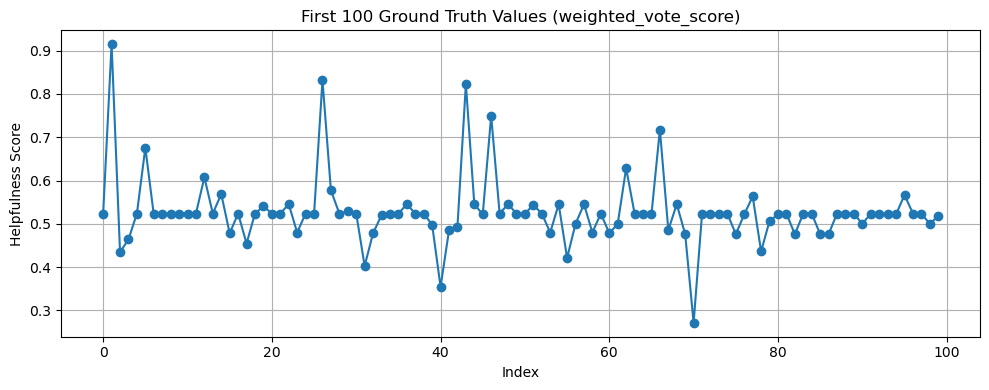

In [8]:
# Ground Truth Plot
import matplotlib.pyplot as plt

ground_truth = df_cleaned.select("weighted_vote_score").limit(100).rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 4))
plt.plot(ground_truth, marker='o')
plt.title("First 100 Ground Truth Values (weighted_vote_score)")
plt.xlabel("Index")
plt.ylabel("Helpfulness Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

numeric_cols = [
    "author_num_games_owned",
    "author_num_reviews",
    "author_playtime_forever",
    "author_playtime_last_two_weeks",
    "author_playtime_at_review",
    "author_last_played",
    "voted_up",
    "votes_up",
    "votes_funny",
    "comment_count",
    "steam_purchase",
    "received_for_free",
    "written_during_early_access"
]

# Cast target to Double
df = df_cleaned.withColumn("label", df_cleaned["weighted_vote_score"].cast("double"))

# Assemble numeric features
assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="raw_features",
    handleInvalid="skip"
)

# Scale for better convergence
scaler = StandardScaler(
    inputCol="raw_features",
    outputCol="features",
    withMean=True,
    withStd=True
)

# Linear regression estimator
lr = LinearRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=50,
    regParam=0.1,
    elasticNetParam=0.0
)

# Build pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Regression function
def lin_reg(x):
  # Train/Test split
  train, test = df.randomSplit([x, 1-x], seed=42)

  # Fit model
  model = pipeline.fit(train)

  # Predict & evaluate
  train_predictions = model.transform(train)
  test_predictions = model.transform(test)
    
  # Plot overlay of ground truth and predictions at 0.8/0.2 train test split  
  if x == 0.8:
      pred_df = test_predictions.select("label", "prediction").limit(100).toPandas()
      plt.figure(figsize=(10,4))
      plt.plot(pred_df["label"],    marker="o", linestyle="-", label="Ground Truth")
      plt.plot(pred_df["prediction"], marker="x", linestyle="--", label="Prediction")
      plt.title("First 100: Ground Truth's vs. Model Prediction")
      plt.xlabel("Index")
      plt.ylabel("Helpfulness Score")
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()
  evaluator = RegressionEvaluator(
      labelCol="label",
      predictionCol="prediction",
      metricName="rmse"
  )
  train_rmse = evaluator.evaluate(train_predictions)
  print(f"Train RMSE = {train_rmse:.4f}")
  test_rmse = evaluator.evaluate(test_predictions)
  print(f"Test RMSE = {test_rmse:.4f}")

  # Print learned coefficients
  lr_model = model.stages[-1]
  coefficients = {}
  for feature, coef in zip(numeric_cols, lr_model.coefficients):
      coefficients[feature] = coef
      print(f"{feature:>30}: {coef:.4f}")
      
  return train_rmse, test_rmse, coefficients

RMSE Values for train size 0.1
Train RMSE = 0.0678
Test RMSE = 0.0678
        author_num_games_owned: 0.0017
            author_num_reviews: -0.0031
       author_playtime_forever: 0.0003
author_playtime_last_two_weeks: 0.0001
     author_playtime_at_review: 0.0006
            author_last_played: -0.0003
                      voted_up: 0.0058
                      votes_up: 0.0079
                   votes_funny: 0.0031
                 comment_count: 0.0017
                steam_purchase: 0.0007
             received_for_free: -0.0003
   written_during_early_access: -0.0003
RMSE Values for train size 0.2
Train RMSE = 0.0681
Test RMSE = 0.0680
        author_num_games_owned: 0.0017
            author_num_reviews: -0.0031
       author_playtime_forever: 0.0003
author_playtime_last_two_weeks: 0.0001
     author_playtime_at_review: 0.0006
            author_last_played: -0.0003
                      voted_up: 0.0058
                      votes_up: 0.0073
                   votes_funny: 0.0

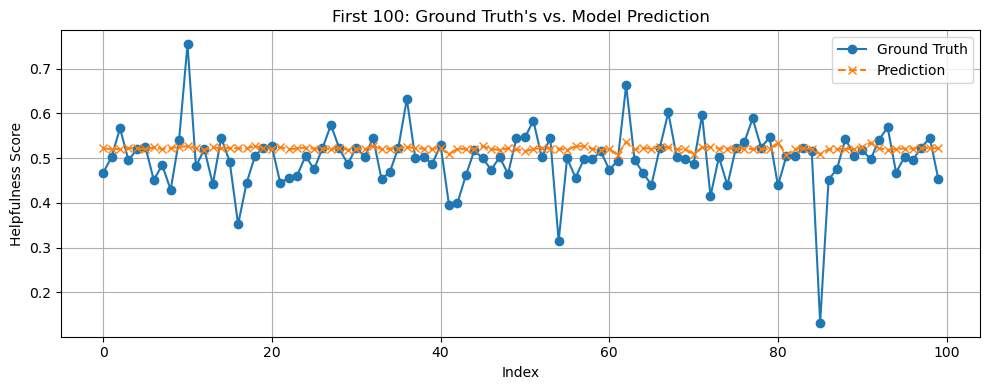

Train RMSE = 0.0679
Test RMSE = 0.0677
        author_num_games_owned: 0.0018
            author_num_reviews: -0.0031
       author_playtime_forever: 0.0003
author_playtime_last_two_weeks: 0.0002
     author_playtime_at_review: 0.0006
            author_last_played: -0.0003
                      voted_up: 0.0057
                      votes_up: 0.0078
                   votes_funny: 0.0033
                 comment_count: 0.0017
                steam_purchase: 0.0007
             received_for_free: -0.0003
   written_during_early_access: -0.0004
RMSE Values for train size 0.9
Train RMSE = 0.0678
Test RMSE = 0.0677
        author_num_games_owned: 0.0018
            author_num_reviews: -0.0031
       author_playtime_forever: 0.0003
author_playtime_last_two_weeks: 0.0002
     author_playtime_at_review: 0.0006
            author_last_played: -0.0003
                      voted_up: 0.0057
                      votes_up: 0.0078
                   votes_funny: 0.0033
                 comment_co

In [19]:
train_rmse_history = []
test_rmse_history = []
coefficients_history = []
x = [0.1, 0.2, 0.5, 0.8, 0.9]

for train_size in x:
  print(f"RMSE Values for train size {train_size}")
  train_rmse, test_rmse, coefficients = lin_reg(train_size)
  train_rmse_history.append(train_rmse)
  test_rmse_history.append(test_rmse)
  coefficients_history.append(coefficients)

print("\nTraining RMSE values:", train_rmse_history)
print("Testing RMSE values:", test_rmse_history)
print("Coefficients for each train size:", coefficients_history)

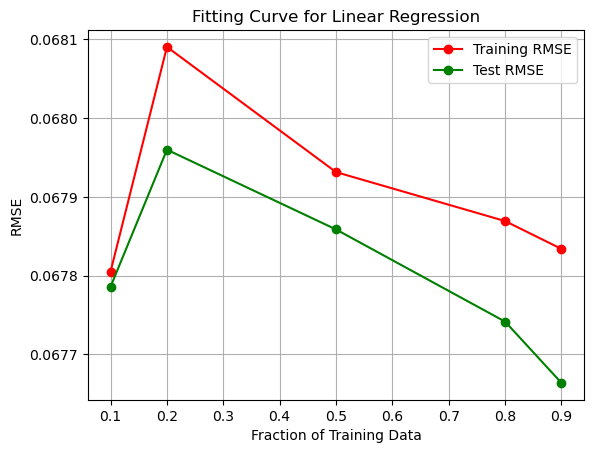

In [20]:
plt.plot(x, train_rmse_history, 'o-', color="r", label="Training RMSE")
plt.plot(x, test_rmse_history, 'o-', color="g", label="Test RMSE")
plt.xlabel("Fraction of Training Data")
plt.ylabel("RMSE")
plt.title("Fitting Curve for Linear Regression")
plt.legend(loc="best")
plt.grid(True)
plt.show()